In [73]:
%load_ext autoreload
%autoreload 2
import numpy as np
# np.seterr(divide='ignore') # these warnings are usually harmless for this code
# np.random.seed(0)
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 12
plt.rcParams.update({'figure.figsize':[18,6]})

import sys
import pyhsmm
import pyhsmm.basic.distributions as distributions

sys.path.append('/home/kirilman/Projects/nir/main nir')
import myutils
import sequence_generator as generator
from HMMClassifier import SignalManager
import pomegranate as pg
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.general import rle
from myutils import plot_signal_label
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# np.random.seed(42)

In [75]:
def abnormals_insert(signal,size = 40):
    t = signal.copy()
    start = np.random.randint(0,len(signal) - size,)
    m = np.random.uniform(min(signal),max(signal))
    sigma = 0.3
    t[start:start+size] = np.random.normal(m,sigma,size)
    return t

from multiprocessing import Pool
def do_log_likelihood(args):
    model, data = args
    ll = []
    for x in data:
        ll += [model.log_likelihood(x.reshape(-1,1))]
    return np.array(ll)

Конструктор


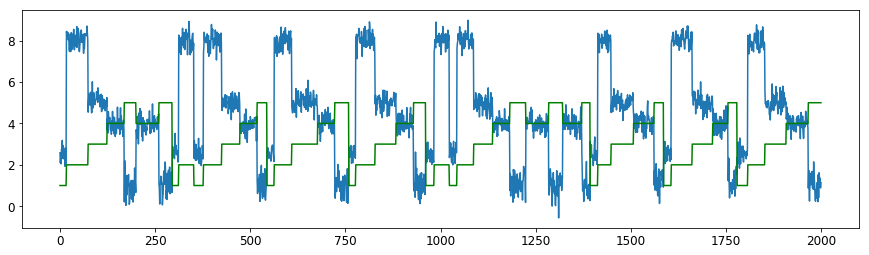

In [76]:
dur_distns = []

trans_matrix = np.array([[0.99, 0.01, 0.0, 0.0, 0.0],
                         [0.02,  0.9,  0.08, 0.0, 0.0],
                         [0.02, 0.0,  0.85, 0.13, 0.0],
                         [0.0,  0.0,  0.0, 0.9, 0.1],
                         [0.08,  0.0,  0.0, 0.02, 0.9]])

Nmax = 5
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }
obs_distns = []
#{1}
obs_hypparams = {'mu':np.array([[2.5]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{2}
obs_hypparams = {'mu':np.array([[8]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{3}
obs_hypparams = {'mu':np.array([[5]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{4}
obs_hypparams = {'mu':np.array([[4]]),
                'sigma':np.array([[0.35**2]]),
                'kappa_0':0.3,
                'nu_0':2}
obs_distns +=[distributions.Gaussian(**obs_hypparams)]
#{5}
obs_hypparams = {'mu':np.array([[1]]),
                'sigma':np.array([[0.5**2]]),
                'kappa_0':0.3,
                'nu_0':2}

obs_distns +=[distributions.Gaussian(**obs_hypparams)]

dur_hypparams = {'lmbda': 20,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda': 45,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda': 50,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda':50,
                 'alpha_0':1,
                 'beta_0':1}
dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

dur_hypparams = {'lmbda':30,
                 'alpha_0':1,
                 'beta_0':1}

dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#     posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
#             alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)

model = pyhsmm.models.HSMM(
        alpha=0., # На что влияет 
#             gamma=2., # better to sample over these; see concentration-resampling.py
#         init_state_concentration=., # pretty inconsequential
        obs_distns=obs_distns,
        dur_distns=dur_distns,trans_matrix = trans_matrix,
        pi_0 = np.array([1.00, 0.00, 0.0, 0.0, 0.0]))
# model.resample_model()
# model.init_state_distn.pi_0 = [0.99, 0.01, 0.0 ]
# print(model.init_state_distn.pi_0)
# posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
fig = plt.figure(figsize=(15,4))
signal, stateseq = model.generate(2000)
plt.plot(signal)
plt.plot(stateseq+1,'g')

In [77]:
0.35**2

0.12249999999999998

In [78]:
np.random.normal(1,1)

-0.25379828788028314

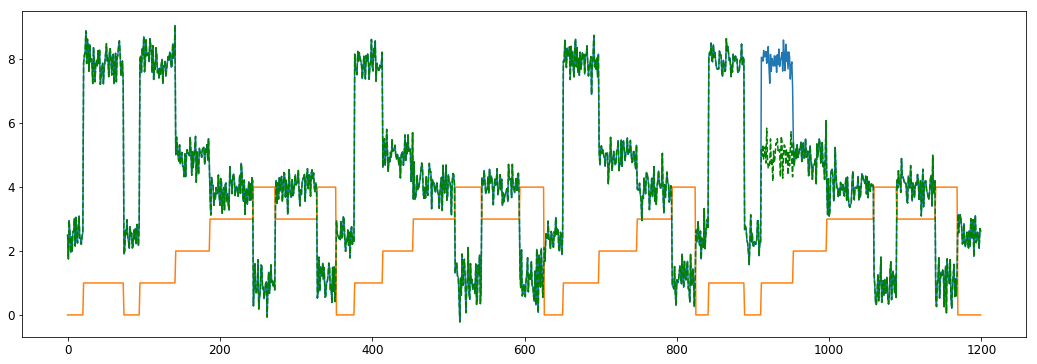

In [79]:
signal_generator = generator.Sequence(1200,type='model', hsmm_model = model)
s = signal_generator.sequence
p = signal_generator.stateseq
plt.plot(s)
plt.plot(p)
an_signal = signal_generator.get_abnormal(dtype='chain_violation',state = 1, state_update=2)
plt.plot(an_signal,'g--')

## Определяем модель и обучаем

In [80]:
#fit model
def create_model(data, Nmax):
    obs_dim = 1
    dur_distns = []
    Nmax = 7
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':45,
                     'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':20,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':30,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
#     dur_hypparams = {'alpha_0':55,
#                      'beta_0':1}
#     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
    
    dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)

#     posteriormodel = pyhsmm.models.HSMM(
#             alpha=6., # На что влияет 
# #             gamma=2., # better to sample over these; see concentration-resampling.py
#             init_state_concentration=6., # pretty inconsequential
#             obs_distns=obs_distns,
#             dur_distns=dur_distns)
    
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model(1)
    plt.show()
    return posteriormodel

In [81]:
from multiprocessing import Pool
class hsmm_classifier():
    def __init__(self, N = 5):
        self.models = []
        self.number_model = N
        
    def fit(self,data):
        pool = Pool(4)
        params = [ (data, i + 10) for i in range(self.number_model)]
        self.models = pool.starmap(self.create_model, params)
        pool.close()
        pool.join()
    def log_likelihood(self, data):
#         pool = Pool(self.number_model)
#         return pool(self.models.log_likelihood, [(data,)*self.number_model])
        return np.array([m.log_likelihood(data) for m in self.models])
    
    def test(self):
        for m in self.models:
            print(m.generate(10,1))
            
    def create_model(self,data,seed):
        np.random.seed(seed)
        obs_dim = 1
        dur_distns = []
        Nmax = 7
    #     L = 5
    #     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
    #                     'K':L,
    #                      'alphav_0':np.zeros(L)+0.1, 
    #                      'alpha_mf':np.zeros(L)+0.1,
    #                     }

        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                        'sigma_0':np.eye(obs_dim),
                        'kappa_0':2,
                        'nu_0':obs_dim+5}
        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]


        dur_hypparams = {'alpha_0':45,
                         'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':20,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':30,
    #                      'beta_0':1}
    #     dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    #     dur_hypparams = {'alpha_0':55,
    #                      'beta_0':1}
#         dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]

#         dur_distns = [distributions.GeometricDuration(**dur_hypparams) for state in range(Nmax)]

        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

    #     posteriormodel = pyhsmm.models.HSMM(
    #             alpha=6., # На что влияет 
    # #             gamma=2., # better to sample over these; see concentration-resampling.py
    #             init_state_concentration=6., # pretty inconsequential
    #             obs_distns=obs_distns,
    #             dur_distns=dur_distns)

        posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
        for idx in progprint_xrange(150):
            posteriormodel.resample_model(1)
        return posteriormodel
    def get_models(self):
        return self.models

In [82]:
classifiear = hsmm_classifier(N = 8)
classifiear.fit(signal.reshape(-1,1))

Конструктор
Конструктор
Конструктор
Конструктор


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


...............................................................................................  [  25/150,    1.36sec avg, ETA 02:50 ]
...  [  25/150,    1.42sec avg, ETA 02:58 ]
..  [  25/150,    1.45sec avg, ETA 03:01 ]
.  [  25/150,    1.45sec avg, ETA 03:01 ]
.............................................................................................  [  50/150,    1.48sec avg, ETA 02:28 ]
..  [  50/150,    1.48sec avg, ETA 02:28 ]
.....  [  50/150,    1.52sec avg, ETA 02:32 ]
.  [  50/150,    1.54sec avg, ETA 02:34 ]
............................................................................................  [  75/150,    1.44sec avg, ETA 01:48 ]
...  [  75/150,    1.45sec avg, ETA 01:49 ]
...  [  75/150,    1.47sec avg, ETA 01:50 ]
...  [  75/150,    1.48sec avg, ETA 01:51 ]
...........................................................................................  [ 100/150,    1.38sec avg, ETA 01:09 ]
...  [ 100/150,    1.39sec avg, ETA 01:10 ]
...  [ 100/150,    1.40sec av

### Генерация тестовых данных {400}

[array([0.35]), array([0.35]), array([0.35]), array([0.35]), array([0.5])]


array([2.37455528, 2.37455528, 2.37455528, ..., 2.37455528, 2.37455528,
       2.37455528])

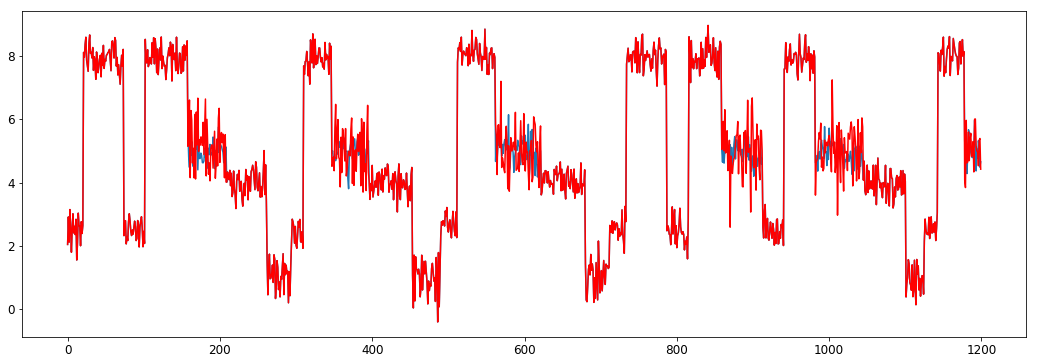

In [83]:
T = 1200
signal_generator = generator.Sequence(T,type='model', hsmm_model = model)
print(signal_generator.variance)
signal = signal_generator.sequence
# an_signal = signal_generator.get_abnormal(dtype='chain_violation',state = 1, state_update=2, count_segment=2)
an_signal = signal_generator.get_abnormal(dtype='varience',state=[2],varience_coef = 2)

an_signal = an_signal.reshape(-1,1)

plt.plot(signal)
plt.plot(an_signal,'r')
np.where(signal_generator.stateseq == 1,1,np.std(signal))

400 1200


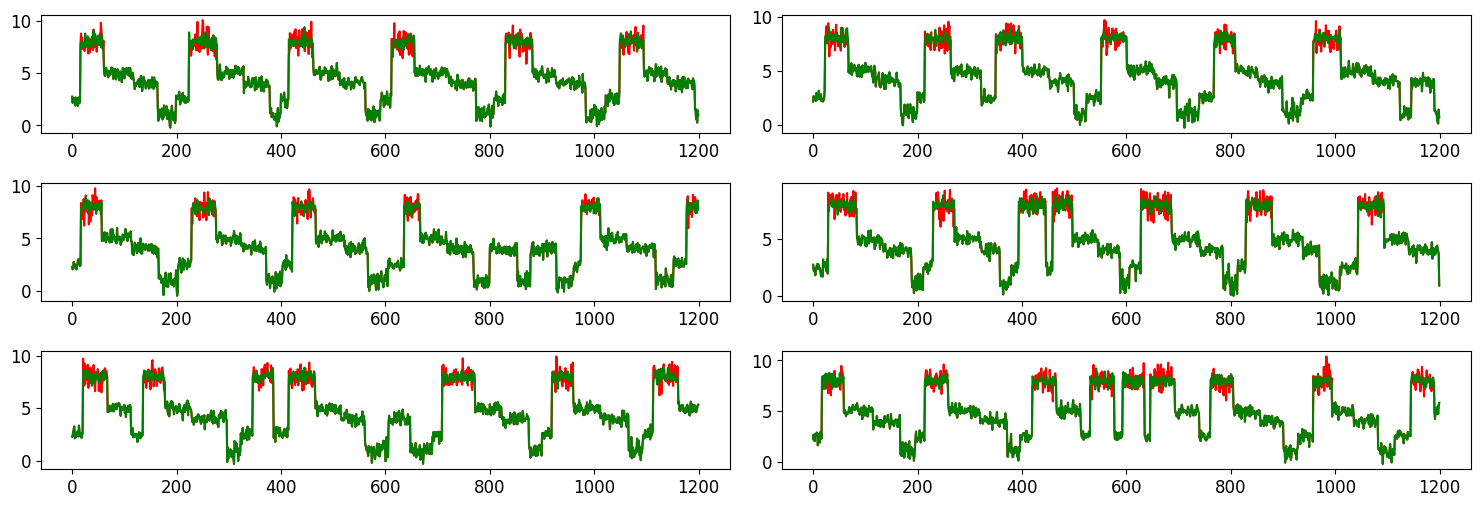

In [84]:
x_test = []
M = 200
# signal_manager.generators[0].n = T
T = 1200
y_true = np.array([0]*M+[1]*M)
# for i in range(M):
#     x_test +=[model.generate(T)[0].reshape(-1,1)]
    
normal_signal = []
abnormal_signal = []
for i in range(M):
    signal_generator = generator.Sequence(T,type='model', hsmm_model = model)
    an_signal = signal_generator.get_abnormal(dtype='varience',state=[1],varience_coef = 2)
#     an_signal[np.random.randint(0,1200)] = 11
    normal_signal +=[np.array(signal_generator.sequence).reshape(-1,1)]
    abnormal_signal +=[an_signal.reshape(-1,1)]
#     x_test+=[an_signal.reshape(-1,1)]
x_test = normal_signal + abnormal_signal    

print(len(x_test),len(x_test[0]))
#Графики сигналов
fig = plt.figure(figsize=(15,10), dpi = 100)
for i,(x,y) in enumerate(zip(x_test,x_test[M:M+6])):
    ax = plt.subplot(6,2,i+1)
    plt.plot(y,'r')
    plt.plot(x,'g')
plt.tight_layout()

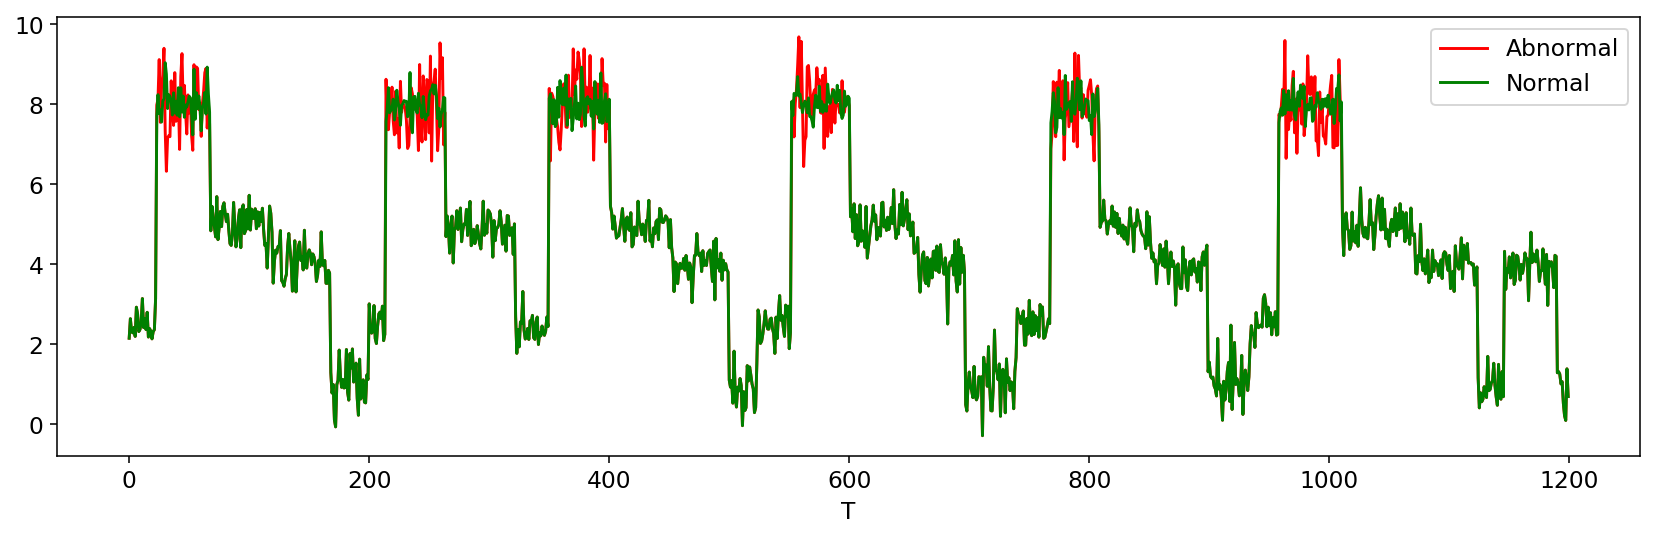

In [85]:
plt.figure(figsize=(12,4),dpi = 140)
plt.plot(x_test[201],'r',label='Abnormal',linewidth=1.5)
plt.plot(x_test[1],'g',label='Normal',linewidth=1.5)

plt.xlabel('T')
plt.tight_layout()
plt.legend(loc=1)
plt.savefig('Normal_abnormal_signal.jpeg',dpi=200,quality = 100)

In [86]:
%%time
pool = Pool()
x_test = np.array(x_test)

ll = pool.map(do_log_likelihood, [ (m, x_test) for m in classifiear.models])

pool.close()
pool.join()

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))
/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


CPU times: user 287 ms, sys: 78.2 ms, total: 365 ms
Wall time: 5min 53s


In [87]:
signal.shape

(1200,)

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


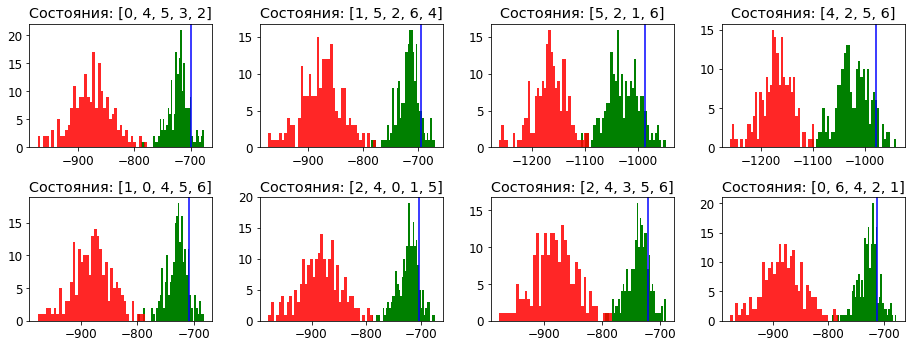

In [90]:
ll_normal = classifiear.log_likelihood(signal[:1200].reshape(-1,1))
fig = plt.figure(figsize=(13,5))
for i in range(classifiear.number_model):
    plt.subplot(2,int(classifiear.number_model/2),i+1)
#     plt.subplot(2,int(classifiear.number_model),i+1)
    plt.hist(ll[i][:200],40, color = 'green')
    plt.title('Состояния: {}'.format(classifiear.models[i].used_states))
    plt.hist(ll[i][200:],40, color = 'red', alpha = 0.85)
    plt.axvline(ll_normal[i],color='blue')
plt.tight_layout()

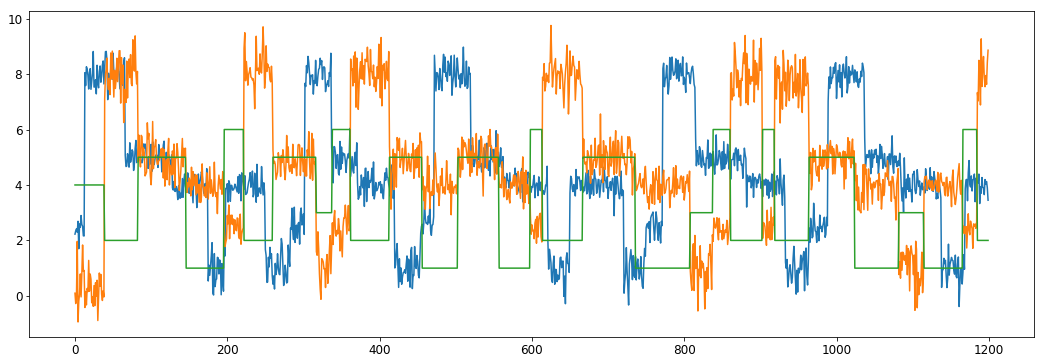

In [67]:
s,p = classifiear.models[2].generate(1200)
plt.plot(signal[:1200])
plt.plot(s)
plt.plot(p)

In [68]:
x_an = x_test[0].copy()
x_an[160] = 9
x_an[150] = 9
x_an[30] = 9

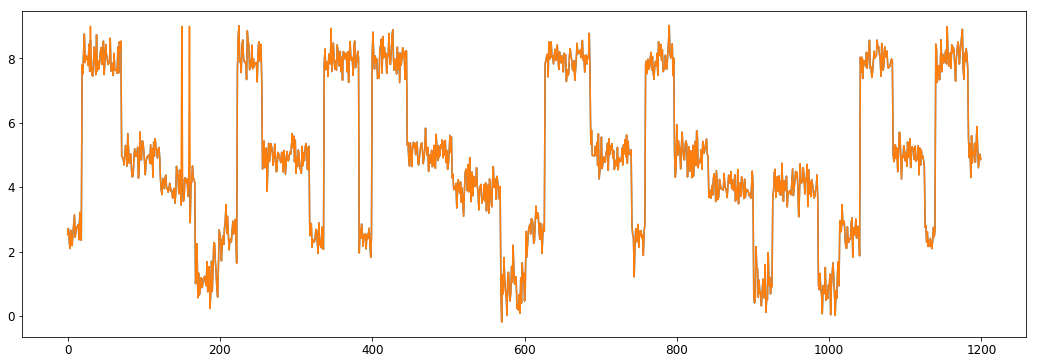

In [69]:
plt.plot(x_test[0])
plt.plot(x_an)

In [70]:
print('ll train: {} , test: {}'.format(classifiear.models[1].log_likelihood(x_test[0].reshape(-1,1)),
                                       classifiear.models[1].log_likelihood(abnormal)))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


NameError: name 'abnormal' is not defined

In [71]:
print(np.argmax(ll_normal))
print(ll_normal)

2
[ -732.91656824 -1027.48601469  -714.86429728]


In [72]:
for i,m in enumerate(classifiear.models):
    print(m.used_states)
    print(m.num_states)
    print('model {}:\n'.format(i))
#     plt.plot(m.durations[0])
#     m.plot_duration()
    used_states = m.used_states
    for k,dist in enumerate(m.obs_distns):
        if k in used_states:
            print('Used***Состояние: {} , {}'.format(k,dist.params))
        else:
            print('Состояние: {} , {}'.format(k,dist.params))
#     print(m.obs_distns[0].params)

[6, 3, 5, 0, 4]
7
model 0:

Used***Состояние: 0 , {'mu': array([3.97524274]), 'sigma': array([[0.18316637]])}
Состояние: 1 , {'mu': array([-0.09818276]), 'sigma': array([[0.20961071]])}
Состояние: 2 , {'mu': array([-0.24681055]), 'sigma': array([[0.12644476]])}
Used***Состояние: 3 , {'mu': array([7.96906348]), 'sigma': array([[0.4655809]])}
Used***Состояние: 4 , {'mu': array([1.02791239]), 'sigma': array([[0.28249491]])}
Used***Состояние: 5 , {'mu': array([4.90509094]), 'sigma': array([[0.24066255]])}
Used***Состояние: 6 , {'mu': array([2.43658872]), 'sigma': array([[0.1912261]])}
[5, 6, 1, 4]
7
model 1:

Состояние: 0 , {'mu': array([0.09474697]), 'sigma': array([[0.10060669]])}
Used***Состояние: 1 , {'mu': array([4.35842665]), 'sigma': array([[0.37309282]])}
Состояние: 2 , {'mu': array([0.05035363]), 'sigma': array([[0.0972783]])}
Состояние: 3 , {'mu': array([-0.96947867]), 'sigma': array([[0.47154111]])}
Used***Состояние: 4 , {'mu': array([0.92835604]), 'sigma': array([[0.33026054]])

In [91]:
classifiear.models[7].trans_distn.trans_matrix

array([[0.00000000e+00, 2.22507849e-02, 1.06732923e-01, 1.96905785e-07,
        3.37345416e-03, 3.49824148e-02, 8.32660226e-01],
       [5.45118525e-01, 0.00000000e+00, 4.00286317e-01, 1.44830847e-15,
        4.68171919e-02, 1.71450179e-03, 6.06346457e-03],
       [9.52372086e-02, 8.74453848e-01, 0.00000000e+00, 1.10234575e-07,
        2.89829133e-02, 7.68703978e-04, 5.57215947e-04],
       [4.40558876e-01, 3.20737241e-01, 2.27212677e-01, 0.00000000e+00,
        1.11260351e-02, 1.63880507e-04, 2.01290241e-04],
       [4.05853506e-02, 2.47845897e-01, 6.35353287e-01, 3.74980150e-10,
        0.00000000e+00, 3.71430751e-04, 7.58440351e-02],
       [4.18912243e-01, 1.13821119e-01, 4.66685093e-01, 2.23296349e-16,
        5.04475736e-04, 0.00000000e+00, 7.70692283e-05],
       [3.18498485e-01, 1.14217795e-01, 8.34441752e-02, 4.50114517e-16,
        4.78757195e-01, 5.08234999e-03, 0.00000000e+00]])

In [92]:
for row in classifiear.models[7].states_list[0].trans_matrix:
    for el in row:
        print('{:f}'.format(el),end=' ')
    print()
print()
for row in classifiear.models[0].states_list[0].trans_matrix:
    for el in row:
        print('{:f}'.format(el),end=' ')
    print()

0.000000 0.022251 0.106733 0.000000 0.003373 0.034982 0.832660 
0.545119 0.000000 0.400286 0.000000 0.046817 0.001715 0.006063 
0.095237 0.874454 0.000000 0.000000 0.028983 0.000769 0.000557 
0.440559 0.320737 0.227213 0.000000 0.011126 0.000164 0.000201 
0.040585 0.247846 0.635353 0.000000 0.000000 0.000371 0.075844 
0.418912 0.113821 0.466685 0.000000 0.000504 0.000000 0.000077 
0.318498 0.114218 0.083444 0.000000 0.478757 0.005082 0.000000 

0.000000 0.000000 0.027118 0.072147 0.783361 0.117145 0.000229 
0.063785 0.000000 0.030770 0.394718 0.331922 0.066636 0.112169 
0.523611 0.000000 0.000000 0.328789 0.114129 0.021502 0.011969 
0.037871 0.000000 0.747624 0.000000 0.088283 0.044087 0.082135 
0.325180 0.000000 0.075160 0.132297 0.000000 0.467363 0.000000 
0.469583 0.000000 0.008454 0.371181 0.149235 0.000000 0.001548 
0.466868 0.000000 0.007323 0.244513 0.211826 0.069471 0.000000 


In [40]:
def score(model, x_test, y_test, log_prob_normal ,train_signal,num_plot,lvl = 0.1, signal_for_lvl = None, 
          degree_std = 3):
    
    x_test = np.array(x_test)
    log_scores = []
    anomals = []
    if signal_for_lvl is None:
        low = log_prob_normal*(1-lvl)
        high = log_prob_normal*(1+lvl)
        if log_prob_normal<0:
            low, high = high, low
    else:
        ll = np.array([model.log_likelihood( np.array(s).reshape(-1,1)) for s in signal_for_lvl])
        mean, std = norm.fit(ll)
        low = mean - degree_std*std
        high = log_prob_normal + 5*std
        print('mean = {}, std = {}'.format(mean, std))
        
    print('Нижний порог {}, верхний порог {}'.format(low, high))
    y_pred = np.zeros(shape=(len(x_test),),dtype=np.int)
    
    start_time = time()
    for k,x in enumerate(x_test):
        p = model.log_likelihood(x.reshape(-1,1))
        if k == 1:
            print(p)
        log_scores+=[p]
        if p<low:
            anomals+=[x]
            y_pred[k] = 1
    log_scores = np.array(log_scores)
    print('Время для log-like: ', time() - start_time)
    print(len(anomals))
    print('Y_pred ', y_pred.sum())
    
#     return log_scores, y_pred
    f_score = f1_score(y_test, y_pred)

#Гистограмма ll
    #для нормальный
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
    fig = plt.figure(dpi = 90, figsize=(12,6))
    plt.hist(log_scores[y_test == 0],int(x_test.shape[0]/8),rwidth = 0.9, color='green');
    plt.axvline(x=log_prob_normal)
    plt.axvline(low,color='black')
    plt.ylabel('N')
    plt.xlabel('Log-likelihood')
    #для аномальных
    plt.hist(log_scores[y_test == 1],int(x_test.shape[0]/8),color = 'r',alpha = 0.8, rwidth = 0.9);
    plt.savefig('Гистограмма.jpeg', dpi = 150);
    
    fig = plt.figure(figsize=(18,5*num_plot))
#     plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g')
        k = np.random.choice(len(anomals))
        plt.plot(anomals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как аномальные.jpeg',dpi = 80)
#     print('x_test',x_test.shape)
#     print('index',np.where(y_pred == 0))    
#     print('y_pred',y_pred.shape)
#     print(x_test[np.where(y_pred == 0)])    
#     print(x_test[np.where(y_pred == 0)].shape)    

    fig = plt.figure(figsize=(18,5*num_plot))
    plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12)
    
    normals = x_test[y_pred == 0]
    
    print('normals',normals.shape)
    for i in range(num_plot):
        ax = plt.subplot(num_plot, 1, i+1)
        plt.plot(train_signal,'g');
        k = np.random.choice(len(normals))
        plt.plot(normals[k],'r--');
    # plt.tight_layout()
    plt.savefig('Как нормальные.jpeg',dpi = 80)
    return log_scores, y_pred,low

In [94]:
ll_t = np.array([classifiear.models[0].log_likelihood( np.array(s).reshape(-1,1)) for s in signal_for_lvl])
norm.fit(ll_t)
print(np.std(ll_t))

NameError: name 'signal_for_lvl' is not defined

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


mean = -259.1778349338598, std = 11.509801667698971
Нижний порог -282.19743826925776, верхний порог -228.0239947969937
-240.09121731380714
Время для log-like:  99.04972338676453
217
Y_pred  217
normals (183, 1200)
CPU times: user 1min 42s, sys: 63.2 ms, total: 1min 42s
Wall time: 1min 42s


/home/kirilman/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


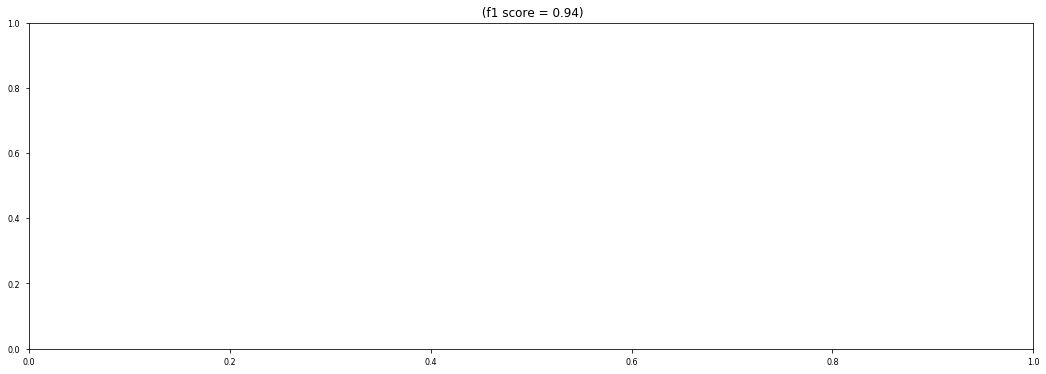

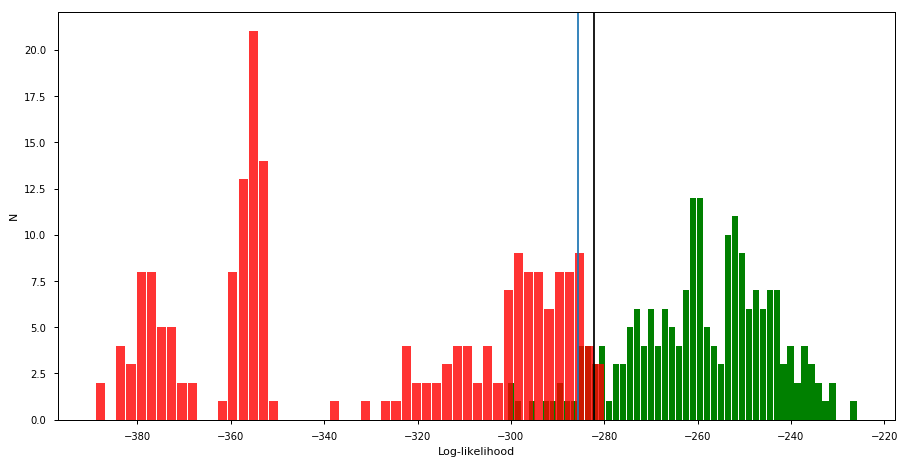

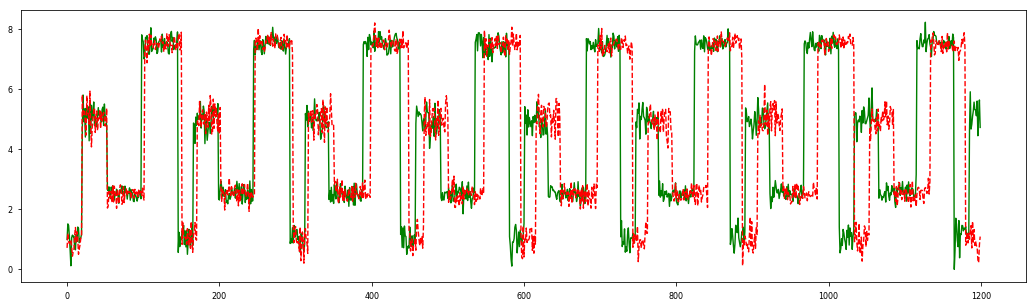

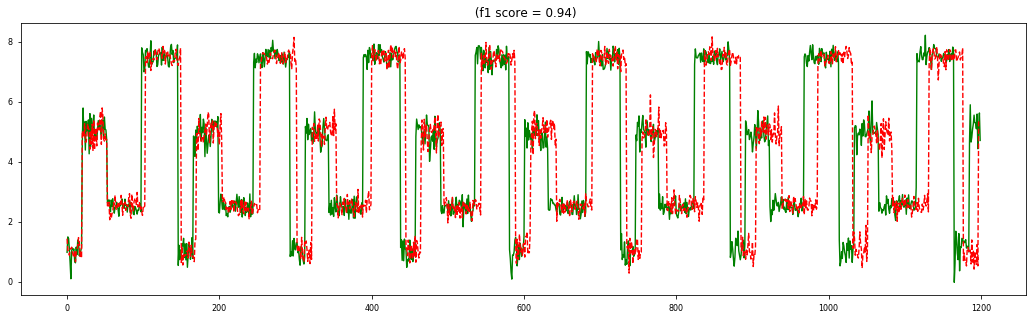

In [56]:
%%time
x_, y_,low_lvl = score(classifiear.models[0],x_test,y_true, classifiear.models[5].log_likelihood(signal[:T]), signal[:T], num_plot=1,lvl = 0.08,
               signal_for_lvl = signal_for_lvl, degree_std = 2)

In [ ]:
model_number = 2
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(ll[model_number], 60,rwidth = 0.95);
plt.ylabel('N')
plt.xlabel('Log-likelihood')
# plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(ll[model_number][y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
# plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(ll[model_number][y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);

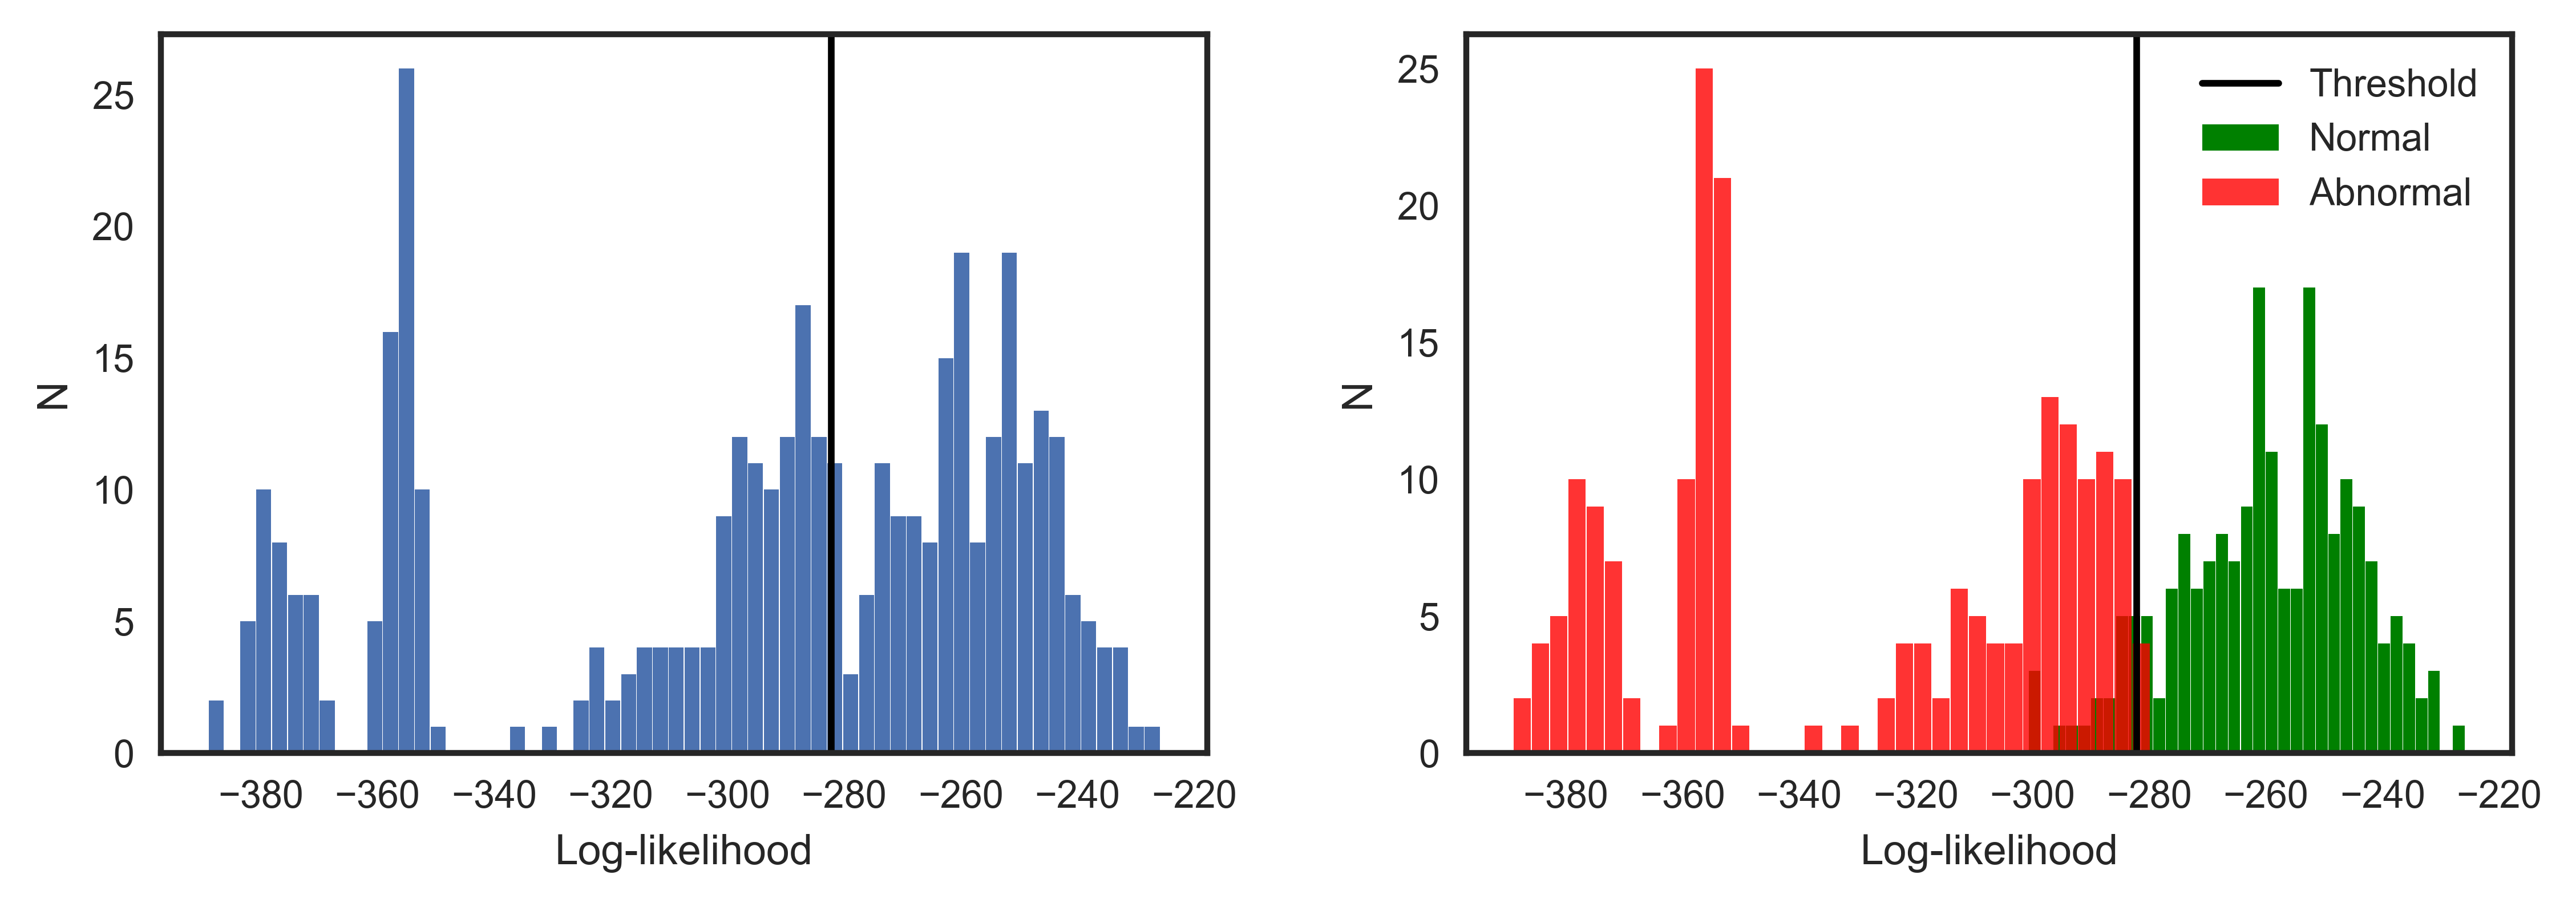

In [73]:
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(x_, 60,rwidth = 0.95);
plt.ylabel('N')
plt.xlabel('Log-likelihood')
plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(x_[y_true == 0],35,rwidth = 0.95, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(x_[y_true == 1],35,color = 'r',alpha = 0.8, rwidth = 0.95,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);


In [105]:
from matplotlib import pyplot as plt
%matplotlib inline
int(x_test.shape[0]/8)

50

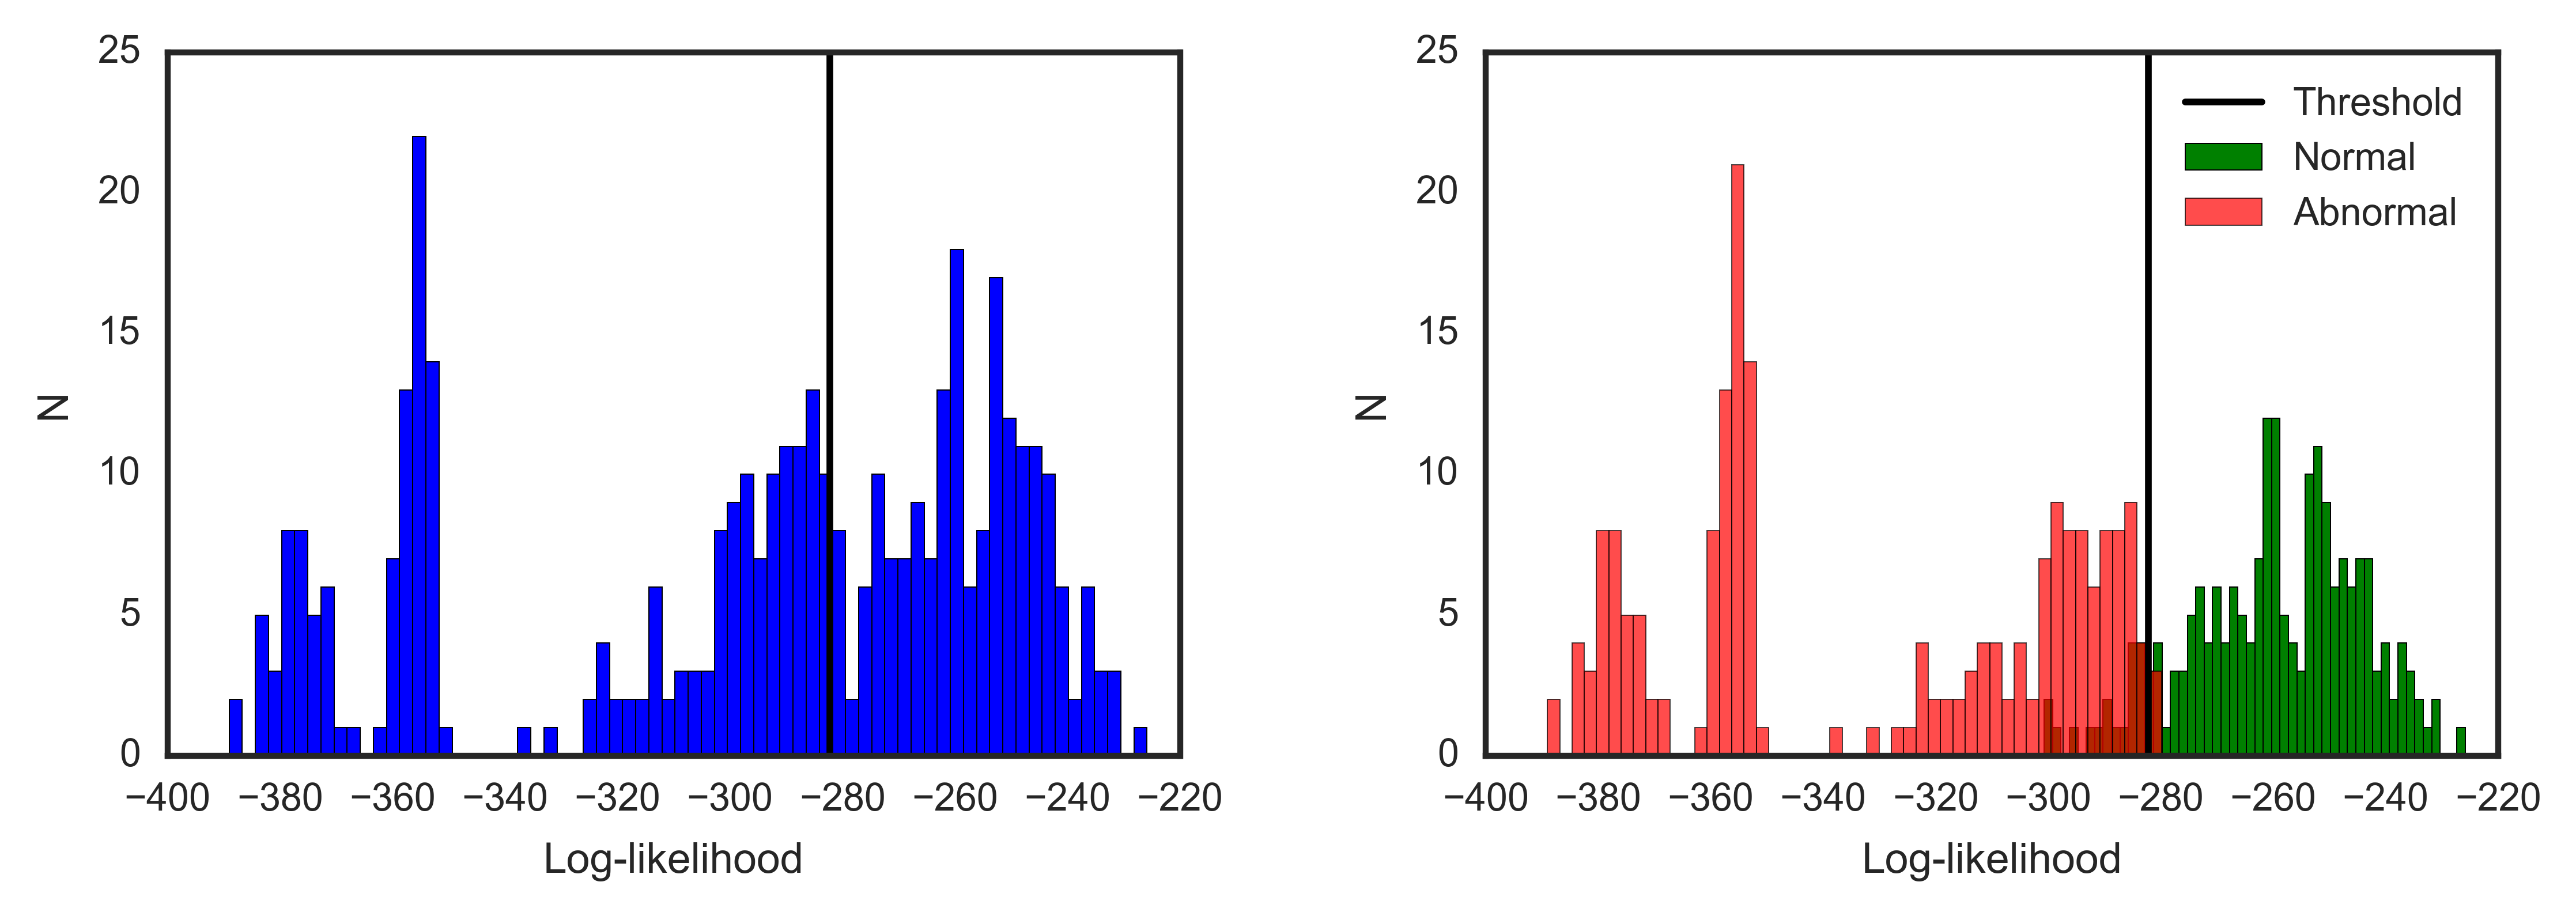

In [111]:
fig = plt.figure(figsize=(8,3.2), dpi = 600,)
plt.style.use('seaborn-paper')
matplotlib.rcParams['font.size'] = 25
plt.subplot(1,2,1)
plt.hist(x_, 70,rwidth = 1, color = 'b');
plt.ylabel('N')
plt.xlabel('Log-likelihood')
plt.axvline(low_lvl,color='black',label='Threshold')


plt.subplot(1,2,2)
# plt.title(' (f1 score = {:.2f})'.format(f_score),fontsize = 12);
plt.hist(x_[y_true == 0],50,rwidth = 1, color='green',label='Normal');
# plt.axvline(x=classifiear.models[5].log_likelihood(signal[:T]))
plt.axvline(low_lvl,color='black', label='Threshold')
plt.ylabel('N')
plt.xlabel('Log-likelihood')
#для аномальных
plt.hist(x_[y_true == 1],50,color = 'r',alpha = 0.7, rwidth = 1,label='Abnormal');

plt.legend()
plt.tight_layout()

plt.savefig('Гистограмма.tif', dpi = 300,quality=100);


### Метрика F1, score ..

In [104]:
from sklearn.metrics import recall_score,accuracy_score,precision_score
print(f1_score(y_, y_true))
print(precision_score(y_, y_true))
print(recall_score(y_,y_true))


0.9448441247002398
0.985
0.9078341013824884


In [170]:
print(f1_score(y_, y_true))
print(precision_score(y_, y_true))
print(recall_score(y_,y_true))


0.9503916449086162
0.91
0.994535519125683


In [ ]:
plt.plot(x_test[260])
ll = np.array([hsmm.log_likelihood(np.array(x_test[260][:i]).reshape(-1,1)) if i > 5 else 0.0 
                                                            for i in range(len(x_test[0]))])
plt.plot(ll)

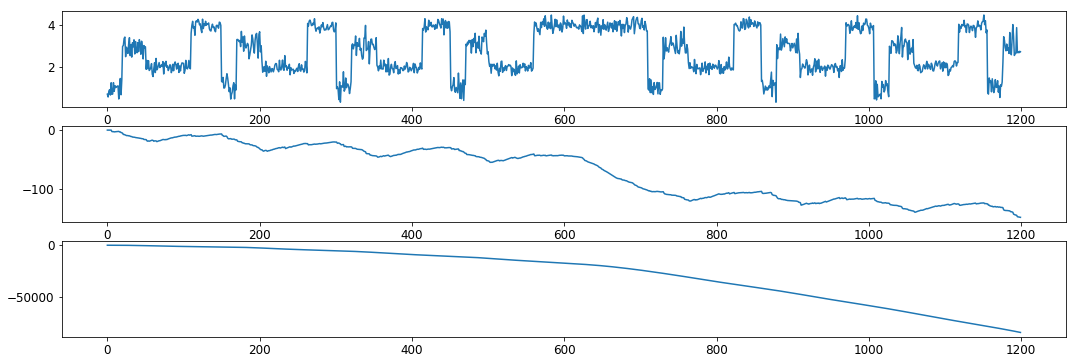

In [47]:
plt.subplot(3,1,1)
plt.plot(x_test[260])
plt.subplot(3,1,2)
plt.plot(ll)
plt.subplot(3,1,3)
# plt.plot(np.diff(ll,1))
plt.plot(np.cumsum(ll))

## Проверка инициализации разных моделей

In [41]:
%%time
signals = np.array(x_test)
for i,x in enumerate(signals):
    if i == 0:
        ll = classifiear.log_likelihood(x.reshape(-1,1))
    else:
        ll = np.vstack((ll, classifiear.log_likelihood(x.reshape(-1,1))))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


CPU times: user 18min 3s, sys: 5.44 s, total: 18min 8s
Wall time: 18min 9s


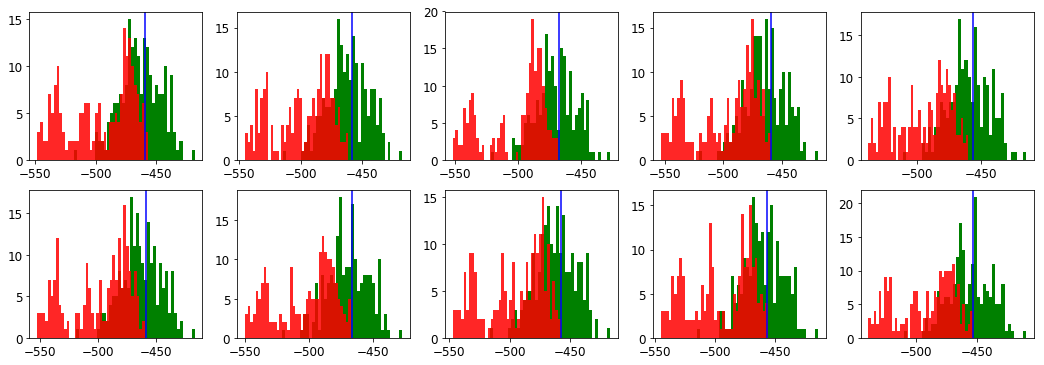

In [43]:
ll_normal = classifiear.log_likelihood(signal[:1200])
plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(ll[:200,i],40, color = 'green')
    plt.hist(ll[200:,i],40, color = 'red', alpha = 0.85)
    plt.axvline(ll_normal[i],color='blue')

In [47]:
for m in classifiear.models:
    print(m.used_states)

[6, 4, 1]
[3, 6, 1]
[0, 2, 5]
[1, 5, 4]
[1, 4, 6]
[3, 2, 4]
[2, 3, 5]
[3, 4, 6]
[2, 0, 3]
[1, 5, 6]


### Оценка нижнего порога

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,10,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')
plt.axvline(mean - 3*std)

In [ ]:
ind = np.where((x_> - 525) & (y_true == 1))
fig = plt.figure(figsize=(20,40))
for i,x in enumerate(np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(signal[:T],'r')
    plt.plot(x)
    if i == 30:
        break

In [ ]:
fig = plt.figure(figsize=(20,4),dpi = 150)
plt.plot(x_, linewidth=2,)
plt.plot(range(len(x_)),[hsmm.log_likelihood(signal[:T])]*len(x_),'green', linewidth=2,label = 'Log-likelihood для обучения')
plt.xlabel('№ сигнала')
plt.ylabel('Log-likelihood')
plt.legend()
plt.savefig('log.jpeg',dpi = 150)

In [ ]:
states = hsmm.predict(np.array(x_test[150]).reshape(-1,1),1)[1]
plt.plot(np.array(x_test[150]))
plt.plot(states)

In [ ]:
np.array(x_test[0]).reshape(-1,1).shape

In [ ]:
%time z = [hsmm.log_likelihood(np.array(x_test[0]).reshape(-1,1))for i in range(100)]

In [ ]:
f1_score(y_true, y_)

In [ ]:
print(np.sum(y_[:100]))
ind = list(filter( lambda x: x< 100, np.where(y_ == 1)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for ll, x in zip(x_[ind], np.array(x_test)[ind]):
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    plt.plot(signal[:T],'r')
    plt.title('{}'.format(ll))
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [ ]:
ind = list(filter( lambda x: x> 100, np.where(y_ == 0)[0]))
print(ind)
i = 0
fig = plt.figure(figsize=(20,40))

for x in np.array(x_test)[ind]:
    plt.subplot(15,2,i+1,); i+=1
    plt.plot(x)
    if i == 30:
        break
plt.show()

In [ ]:
signals = []
for i in range(1000):
    signals+=[signal_manager.generators[0].generate_signal()[:T]]
signals = np.array(signals)
ll = np.zeros((1000,))
for k, x in enumerate(signals):
    ll[k] = hsmm.log_likelihood(x.reshape(-1,1))

In [ ]:
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import logistic

plt.hist(ll,30,color='r', normed=True);
mean, std = norm.fit(ll)
xx = np.linspace(mean - 5*std, mean + 5*std,200)
print(mean, std)
pdf = norm.pdf(xx,mean, std)
plt.plot(xx,pdf,color='black')

loc, scale = logistic.fit(ll)
laplace_pdf = logistic.pdf(xx,loc, scale)

plt.plot(xx, laplace_pdf,'green')

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores>-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным.jpeg',dpi = 80)

In [ ]:
fig = plt.figure(figsize=(20,80))
for i in range(20):
    ax = plt.subplot(20, 1, i+1)
    plt.plot(signal,'g')
    plt.plot(anomals[np.where(log_scores<-240)[0][i]],'r--')
# plt.tight_layout()
plt.savefig('Сравнение аномальный сигналов с нормальным более аномальные.jpeg',dpi = 80)

In [ ]:
models = [ create_model(signal,7) for i in range(5)]

In [ ]:
for model in models:
    print(' ll = ', model.log_likelihood(signal))

##Аномал скор нарастающий

In [ ]:
def compute_anomal_score(model, seq):
    if isinstance(seq, list):
        seq = np.array(seq)
        seq = seq.reshape(-1,1)
    b = np.zeros((seq.shape[0],))
  
    for i in range(seq.shape[0]):
        if i == 0:
            continue
        b[i] = model.log_likelihood(seq[:i])
    return -b.sum()/len(b), b 